In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### `unnorm_prob` is an unnormalized probability function which always outputs a positive number

It is created by removing the coefficient `1/np.sqrt(2*np.pi)/sigma` in Gaussian distribution.

### `norm_prob` is normalized probability

In [530]:
x = np.linspace(-2,2,1000)

def unnorm_prob(x, mu=0, sigma=1):
    z = (x-mu)/sigma
    z = -0.5 * np.power(z, 2)
    return np.exp(z)

def norm_prob(x, mu=0, sigma=1):
    z = (x-mu)/sigma
    z = -0.5 * np.power(z, 2)
    c = 1/np.sqrt(2*np.pi)/sigma
    return c * np.exp(z)

### As you can see, the area under unnormalized distribution does not add up to 1

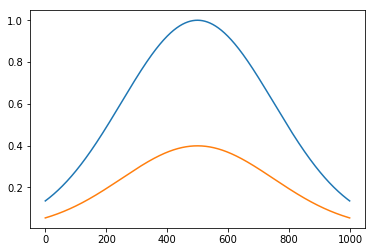

In [531]:
_ = plt.plot([unnorm_prob(i) for i in x])
_ = plt.plot([norm_prob(i) for i in x])

### We get `n=1000` samples from the unnormalized distribution and `n` from normalized

In [532]:
mu, sigma = 0, 1
positives = mu + np.random.randn(1000) * sigma
negatives = mu + np.random.randn(1000) * sigma

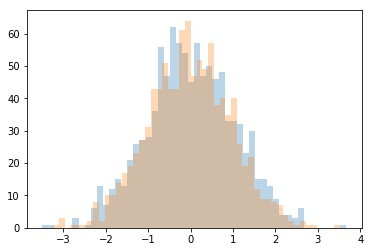

In [533]:
_ = plt.hist(positives, bins=50, alpha=0.3)
_ = plt.hist(negatives, bins=50, alpha=0.3)

In [534]:
norm_prob(torch.Tensor([1.0]))

tensor([0.2420])

### This is the beauty of NCE: we multiply the unnormalized distribution by a coefficient `coeff`. We set the coefficient as the unknown parameter and simply try to minimize cross entropy loss. The value of `coeff` that minimizes the loss is also the value the normalized the unnormalized distribution

In [535]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.coeff = nn.Parameter(torch.Tensor([1.0]))
    
    def forward(self, x):
        num = self.coeff * unnorm_prob(x)
        den = num + norm_prob(x)
        return num / den

In [536]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [537]:
losses = []
for epoch in range(1):
    for i in range(10000):
        label = np.random.choice([0,1])
        dataset = positives if label == 1 else negatives
        x = np.random.choice(dataset)

        x = torch.Tensor([x]).float()
        y = torch.Tensor([label]).float()

        out = model(x)
        loss = -(y * torch.log(out) + (1-y) * torch.log(1-out))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

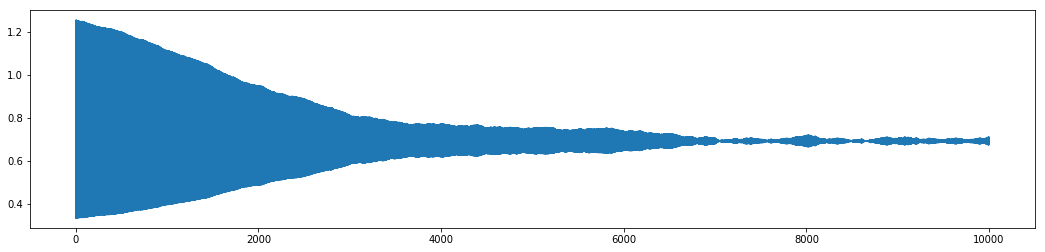

In [538]:
plt.figure(figsize=(18,4))
_ = plt.plot(losses)

### As you can see, `model.coeff` is close to the actual value `1/np.sqrt(2*np.pi)`

In [539]:
model.coeff

Parameter containing:
tensor([0.4133], requires_grad=True)

In [540]:
1/np.sqrt(2*np.pi)

0.3989422804014327

---

## Using a uniform distribution as negative samples

In [541]:
mu, sigma = 0, 1
positives = mu + np.random.randn(1000) * sigma
positives.min(), positives.max()

(-4.587007191005283, 3.1176239093738354)

### This time our negative samples come from a uniform distribution

In [542]:
negatives = np.random.uniform(low=-3.5, high=3.5, size=1000)

In [548]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.coeff = nn.Parameter(torch.Tensor([1.0]))
        
    def norm_prob(self, x, start=-3.5, stop=3.5):
        return 1/(stop-start)
    
    def forward(self, x):
        num = self.coeff * unnorm_prob(x)
        den = num + self.norm_prob(x)
        return num / den

In [572]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

losses = []
for i in range(15000):
    label = np.random.choice([0,1])
    dataset = positives if label == 1 else negatives
    x = np.random.choice(dataset)

    x = torch.Tensor([x]).float()
    y = torch.Tensor([label]).float()

    out = model(x)
    loss = -(y * torch.log(out) + (1-y) * torch.log(1-out))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

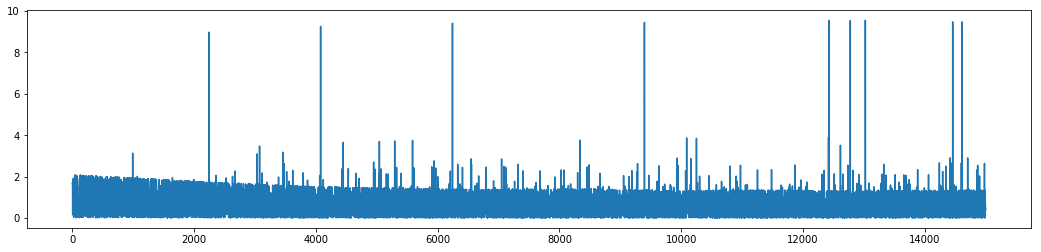

In [573]:
plt.figure(figsize=(18,4))
_ = plt.plot(losses)

### `model.coeff` again converges to `1/np.sqrt(2*np.pi)`

In [574]:
model.coeff.item()

0.41531115770339966

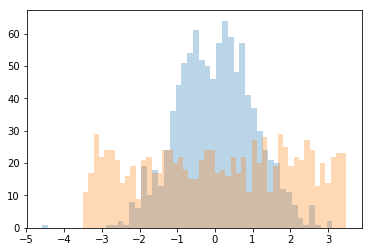

In [575]:
_ = plt.hist(positives, bins=50, alpha=0.3)
_ = plt.hist(negatives, bins=50, alpha=0.3)

---

## Trying to find the right coefficient as well as variance

Now let's assume we don't know the variance of the distribution. NCE can help find both the parameters: variance as well as the normalizing coefficient.

In [576]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.coeff = nn.Parameter(torch.Tensor([1.0]))
        self.sigma = nn.Parameter(torch.Tensor([2.0]))
        
    def unnorm_prob(self, x, mu=0, sigma=1):
        z = (x-mu)/sigma
        z = -0.5 * torch.pow(z, 2)
        return z.exp()
    
    def norm_prob(self, x, mu=0, sigma=1):
        z = (x-mu)/sigma
        z = -0.5 * np.power(z, 2)
        c = 1/np.sqrt(2*np.pi)/sigma
        return c * z.exp()
    
    def forward(self, x):
        num = self.coeff * self.unnorm_prob(x, sigma = self.sigma)
        den = num + self.norm_prob(x)
        return num / den

In [577]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [578]:
losses = []
for epoch in range(1):
    for i in range(20000):
        label = np.random.choice([0,1])
        dataset = positives if label == 1 else negatives
        x = np.random.choice(dataset)

        x = torch.Tensor([x]).float()
        y = torch.Tensor([label]).float()

        out = model(x)
        loss = -(y * torch.log(out) + (1-y) * torch.log(1-out))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

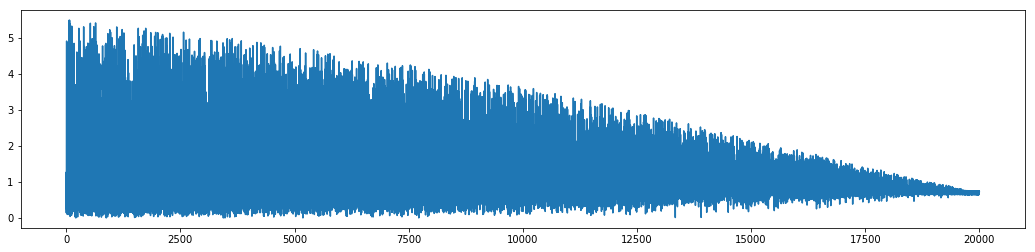

In [579]:
plt.figure(figsize=(18,4))
_ = plt.plot(losses)

### The values are close to the actual values `(0.3989422804014327, 1.0)`

In [580]:
model.coeff.item(), model.sigma.item()

(0.3606971204280853, 1.0110360383987427)

## Trying to estimate mean, variance as well as normalizing coefficient

In [581]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.coeff = nn.Parameter(torch.Tensor([1.0]))
        self.mu = nn.Parameter(torch.Tensor([0.3]))
        self.sigma = nn.Parameter(torch.Tensor([2.0]))
        
    def unnorm_prob(self, x, mu=0, sigma=1):
        z = (x-mu)/sigma
        z = -0.5 * torch.pow(z, 2)
        return z.exp()
    
    def norm_prob(self, x, mu=0, sigma=1):
        z = (x-mu)/sigma
        z = -0.5 * np.power(z, 2)
        c = 1/np.sqrt(2*np.pi)/sigma
        return c * z.exp()
    
    def forward(self, x):
        num = self.coeff * self.unnorm_prob(x, mu=self.mu, sigma=self.sigma)
        den = num + self.norm_prob(x)
        return num / den

In [582]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [583]:
losses = []
for i in range(4000):
    label = np.random.choice([0,1])
    dataset = positives if label == 1 else negatives
    x = np.random.choice(dataset)

    x = torch.Tensor([x]).float()
    y = torch.Tensor([label]).float()

    out = model(x)
    loss = -(y * torch.log(out) + (1-y) * torch.log(1-out))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

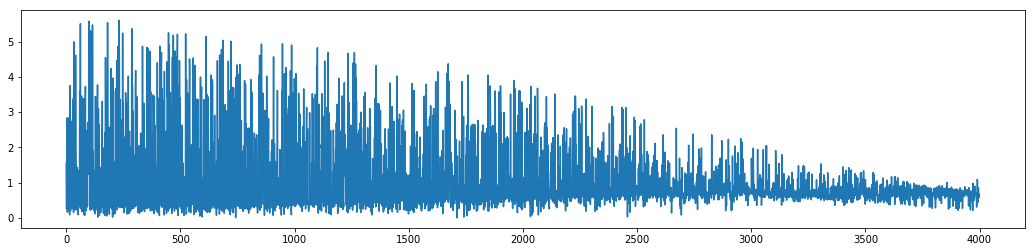

In [584]:
plt.figure(figsize=(18,4))
_ = plt.plot(losses)

### It is harder for the model to learn given small batch size (=1) but the values get close to actual values

In [585]:
model.coeff.item(), model.mu.item(), model.sigma.item()

(0.4117817282676697, 0.17670874297618866, 0.9288307428359985)

---

## Trying to estimate everything about the distribution without assuming anything

Let's say we have no idea that the samples come from a Gaussian distribution. We create a simple NN which outputs a positive value as an unnormalized probability and try to minimize cross entropy loss.

In [592]:
mu, sigma = 0, 1
positives = mu + np.random.randn(1000) * sigma
negatives = mu + np.random.randn(1000) * sigma

In [593]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.unnorm_prob = nn.Sequential(
                    nn.Linear(1,50), 
                    nn.ReLU(True),
                    nn.Linear(50,50),
                    nn.ReLU(True),
                    nn.Linear(50,1)
                )
        
    def norm_prob(self, x, mu=0, sigma=1):
        z = (x-mu)/sigma
        z = -0.5 * np.power(z, 2)
        c = 1/np.sqrt(2*np.pi)/sigma
        return c * z.exp()
    
    def forward(self, x):
        x = x.unsqueeze(0)
        num = self.unnorm_prob(x).squeeze().exp()
        den = num + self.norm_prob(x)
        return num / den

In [594]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [595]:
losses = []
for i in range(1000):
    label = np.random.choice([0,1])
    dataset = positives if label == 1 else negatives
    x = np.random.choice(dataset)

    x = torch.Tensor([x]).float()
    y = torch.Tensor([label]).float()

    out = model(x)
    loss = -(y * torch.log(out) + (1-y) * torch.log(1-out))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i in [0,300,400,600]:
        scheduler.step()

    losses.append(loss.item())

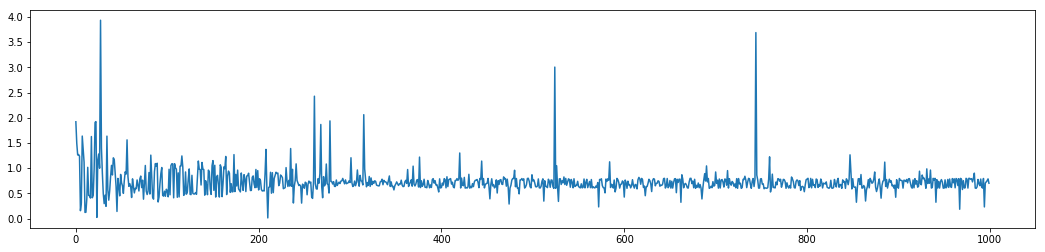

In [596]:
plt.figure(figsize=(18,4))
_ = plt.plot(losses)

In [597]:
x = np.linspace(-4,4,1000)
x_torch = torch.from_numpy(x).unsqueeze(1).float()
with torch.no_grad():
    out = model.unnorm_prob(x_torch).squeeze().exp().numpy()
    
print(x.shape, out.shape)

(1000,) (1000,)


### The model learns the distribution but the learned variance appears to be higher. 

Also I found it relatively harder to train this model. I had to use a scheduler to converge fast and then not diverge again.

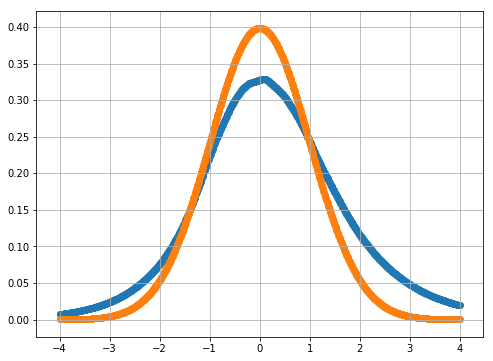

In [603]:
plt.figure(figsize=(8,6))
plt.grid()
_ = plt.scatter(x=x, y=out)
_ = plt.scatter(x=x, y=model.norm_prob(torch.from_numpy(x)).detach().numpy())

### Let's let's a uniform distribution for negative samples

In [633]:
mu, sigma = 0, 1
positives = mu + np.random.randn(1000) * sigma
negatives = np.random.uniform(low=-4, high=4, size=1000)

In [634]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.unnorm_prob = nn.Sequential(
                    nn.Linear(1,50), 
                    nn.ReLU(True),
                    nn.Linear(50,50),
                    nn.ReLU(True),
                    nn.Linear(50,1)
                )
        
    def norm_prob(self, x, start=-4, stop=4):
        return 1/(stop-start)
    
    def forward(self, x):
        x = x.unsqueeze(0)
        num = self.unnorm_prob(x).squeeze().exp()
        den = num + self.norm_prob(x)
        return num / den

In [635]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

losses = []
for i in range(2000):
    label = np.random.choice([0,1])
    dataset = positives if label == 1 else negatives
    x = np.random.choice(dataset)

    x = torch.Tensor([x]).float()
    y = torch.Tensor([label]).float()

    out = model(x)
    loss = -(y * torch.log(out) + (1-y) * torch.log(1-out))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i in [0,300,400,600,800]:
        scheduler.step()

    losses.append(loss.item())

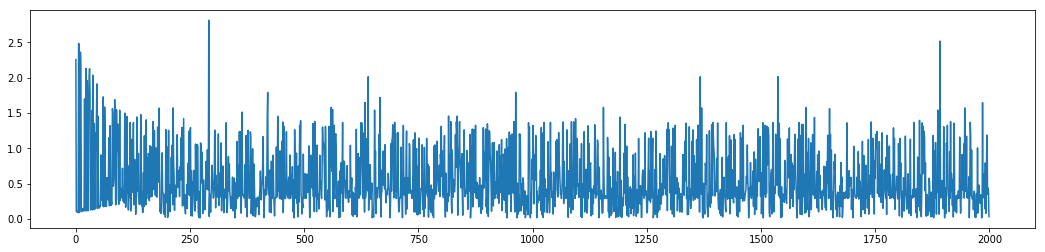

In [636]:
plt.figure(figsize=(18,4))
_ = plt.plot(losses)

### The learned distribution is pretty close to the actual one

In [637]:
def gaussian_prob(x, mu=0, sigma=1):
        z = (x-mu)/sigma
        z = -0.5 * np.power(z, 2)
        c = 1/np.sqrt(2*np.pi)/sigma
        return c * np.exp(z)

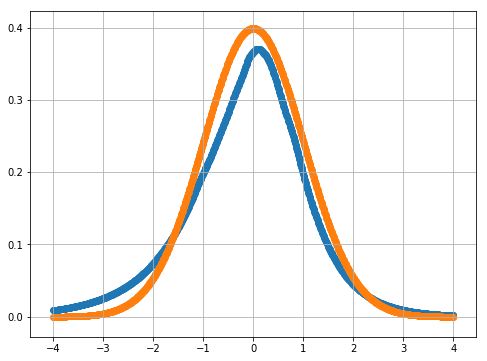

In [638]:
x = np.linspace(-4,4,1000)
x_torch = torch.from_numpy(x).unsqueeze(1).float()
with torch.no_grad():
    out = model.unnorm_prob(x_torch).squeeze().exp().numpy()
    
plt.figure(figsize=(8,6))
plt.grid()
_ = plt.scatter(x=x, y=out)
_ = plt.scatter(x=x, y=gaussian_prob(x))

## Learning to recognize a positive sample out of `n+1` samples (1 positive + `n` negative samples)

Let's fix the number of positive samples to be 1000 and vary the number of negative samples. 

### Estimating the normalizing coefficient

In [639]:
mu, sigma = 0, 1
positives = mu + np.random.randn(1000) * sigma
negatives = np.random.uniform(low=-4, high=4, size=1000)

In [705]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.unnorm_prob = nn.Sequential(
                    nn.Linear(1,50), 
                    nn.ReLU(True),
                    nn.Linear(50,50),
                    nn.ReLU(True),
                    nn.Linear(50,1)
                )
        
    def norm_prob(self, x, start=-4, stop=4):
        return 1/(stop-start)
    
    def forward(self, xp, xn):
        xp = xp.unsqueeze(0)
        num = self.unnorm_prob(xp).squeeze().exp()
        den = num + self.norm_prob(xn)*len(xn)
        return num / den

torch.Size([1]) torch.Size([100])


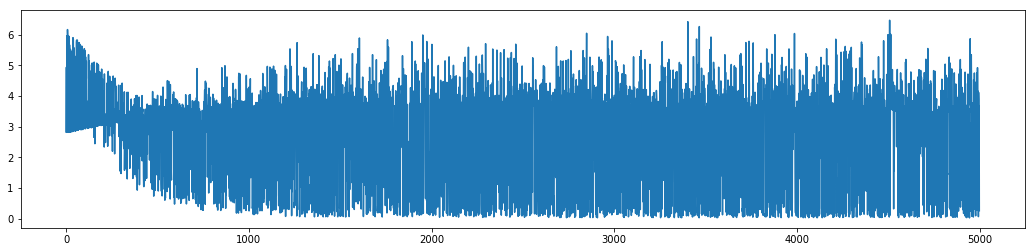

In [710]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

negative_sample_size = 100

losses = []
for i in range(5000):
    label = np.random.choice([0,1])
    dataset = positives if label == 1 else negatives
    
    xp = np.random.choice(dataset)
    xp = torch.Tensor([xp]).float()

    xn = np.random.choice(negatives, size=negative_sample_size)
    xn = torch.Tensor(xn).float()
    
    y = torch.Tensor([label]).float()
    
    if i==0:
        print(xp.shape, xn.shape)

    out = model(xp, xn)
    loss = -(y*torch.log(out) + negative_sample_size*(1-y)*torch.log(1-out))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
        
plt.figure(figsize=(18,4))
_ = plt.plot(losses)

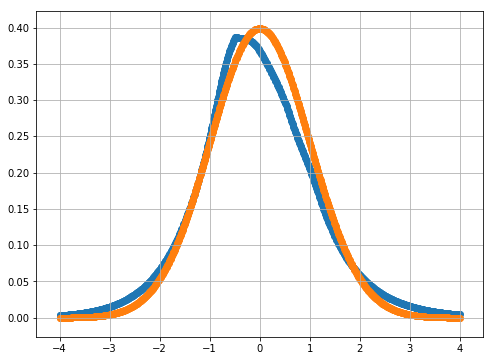

In [711]:
x = np.linspace(-4,4,1000)
x_torch = torch.from_numpy(x).unsqueeze(1).float()
with torch.no_grad():
    out = model.unnorm_prob(x_torch).squeeze().exp().numpy()
    
plt.figure(figsize=(8,6))
plt.grid()
_ = plt.scatter(x=x, y=out)
_ = plt.scatter(x=x, y=gaussian_prob(x))